In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import os
import sys
import matplotlib.pyplot as plt

In [2]:
path_to_pydeformetrica = '../../'
sys.path.append(os.path.join(path_to_pydeformetrica, 'src'))
from in_out.xml_parameters import XmlParameters
from in_out.dataset_functions import create_template_metadata
from in_out.deformable_object_reader import DeformableObjectReader
from core.model_tools.attachments.multi_object_attachment import MultiObjectAttachment
import support.kernels as kernel_factory
from support.utilities.general_settings import Settings
from in_out.array_readers_and_writers import *

In [3]:
path_to_atlas = '/Users/alexandre.bone/Workspace/IJCV_2018/1_starmen/1_simulation_4sources_7visits_5years_0noiseStd/8_longitudinal_atlas_4sources_12'
path_to_output = os.path.join(path_to_atlas, 'output')

In [4]:
# Xml parameters. 
initialized_model_xml_path = os.path.join(path_to_atlas, 'initialized_model.xml')
dataset_xml_path = os.path.join(path_to_atlas, 'data_set.xml')
optimization_parameters_xml_path = os.path.join(path_to_atlas, 'optimization_parameters.xml')

xml_parameters = XmlParameters()
xml_parameters.read_all_xmls(initialized_model_xml_path, dataset_xml_path, optimization_parameters_xml_path)

>> I will use 20 threads, and I set OMP_NUM_THREADS and torch_num_threads to 1.
>> State will be saved in file output/pydef_state.p


In [5]:
path_to_trajectory_txt = os.path.join(path_to_output, 'LongitudinalAtlas__EstimatedParameters__Trajectory.txt')
path_to_trajectory_npy = os.path.join(path_to_output, 'LongitudinalAtlas__EstimatedParameters__Trajectory.npy')
if os.path.isfile(path_to_trajectory_txt):
    trajectory_all_parameters = np.loadtxt(path_to_trajectory_txt)
    number_of_trajectory_points = trajectory_all_parameters.shape[0]
elif os.path.isfile(path_to_trajectory_npy): 
    trajectory_all_parameters = np.load(path_to_trajectory_npy)[()]
    #number_of_trajectory_points = list(trajectory_all_parameters.values())[0].shape[0]
    number_of_trajectory_points = 201
else: 
    raise RuntimeError('No trajectory file !')

# 1. Get initialized parameters

In [6]:
# Template data. 
for template_object_specifications in xml_parameters.template_specifications.values(): 
    path_to_initialized_template = os.path.abspath(os.path.join(path_to_atlas, template_object_specifications['filename']))
    template_type = template_object_specifications['deformable_object_type'].lower()
    attachment_type = template_object_specifications['attachment_type'].lower()
    attachement_kernel_type = template_object_specifications['kernel_type']
    attachement_kernel_width = template_object_specifications['kernel_width']
reader = DeformableObjectReader()
initialized_template = reader.create_object(path_to_initialized_template, template_type)
range_template_data = range(0, initialized_template.get_points().size)

In [7]:
# Control points. 
if Settings().dense_mode: 
    initialized_control_points = initialized_template.get_points()
else:
    path_to_initialized_control_points = os.path.abspath(os.path.join(path_to_atlas, xml_parameters.initial_control_points))
    initialized_control_points = np.loadtxt(path_to_initialized_control_points)
range_control_points = range(range_template_data[-1] + 1, range_template_data[-1] + initialized_control_points.size + 1)

In [8]:
# Momenta. 
path_to_initialized_momenta = os.path.abspath(os.path.join(path_to_atlas, xml_parameters.initial_momenta))
initialized_momenta = read_3D_array(path_to_initialized_momenta)
range_momenta = range(range_control_points[-1] + 1, range_control_points[-1] + initialized_momenta.size + 1)

In [9]:
# Modulation matrix. 
path_to_initialized_modulation_matrix = os.path.abspath(os.path.join(path_to_atlas, xml_parameters.initial_modulation_matrix))
initialized_modulation_matrix = np.loadtxt(path_to_initialized_modulation_matrix)
range_modulation_matrix = range(range_momenta[-1] + 1, range_momenta[-1] + initialized_modulation_matrix.size + 1)

In [10]:
# Reference time. 
initialized_reference_time = xml_parameters.t0
range_reference_time = range(range_modulation_matrix[-1] + 1, range_modulation_matrix[-1] + 2)

In [11]:
# Time-shift variance. 
initialized_time_shift_variance = xml_parameters.initial_time_shift_variance
range_time_shift_variance = range(range_reference_time[-1] + 1, range_reference_time[-1] + 2)

In [12]:
# Log-acceleration variance. 
initialized_log_acceleration_variance = xml_parameters.initial_log_acceleration_variance
range_log_acceleration_variance = range(range_time_shift_variance[-1] + 1, range_time_shift_variance[-1] + 2)

In [13]:
# Noise variance. 
for template_object_specifications in xml_parameters.template_specifications.values(): 
    initialized_noise_variance = template_object_specifications['noise_std'] ** 2
range_noise_variance = range(range_log_acceleration_variance[-1] + 1, range_log_acceleration_variance[-1] + 2)

# 2. Print parameters trajectory

In [14]:
#number_of_trajectory_points = 125
max_number_of_trajectory_points = min(500, xml_parameters.max_iterations)
x = np.linspace(0, xml_parameters.max_iterations, max_number_of_trajectory_points + 1)[:number_of_trajectory_points]

In [15]:
trajectory_all_parameters.keys()

dict_keys(['template_data', 'control_points', 'momenta', 'modulation_matrix', 'reference_time', 'time_shift_variance', 'log_acceleration_variance', 'noise_variance'])

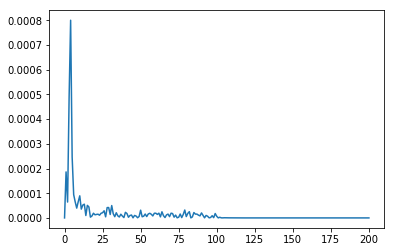

In [16]:
# Template. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_template_data = trajectory_all_parameters[:, range_template_data]
else:
    if 'landmark_points' in trajectory_all_parameters.keys():
        trajectory_template_data = trajectory_all_parameters['landmark_points'][0:number_of_trajectory_points]
    elif 'template_data' in trajectory_all_parameters.keys():
        trajectory_template_data = trajectory_all_parameters['template_data'][0:number_of_trajectory_points]
    else: 
        raise RuntimeError

moa = MultiObjectAttachment()
kernel = kernel_factory.factory('torch', attachement_kernel_width)

template = reader.create_object(path_to_initialized_template, template_type)

trajectory_template = []
for k, template_data in enumerate(trajectory_template_data): 
    template_data_torch = Variable(torch.from_numpy(template_data.reshape((-1, xml_parameters.dimension))).type(Settings().tensor_scalar_type))
    if attachment_type == 'current':
        distance = moa._current_distance(template_data_torch, template, initialized_template, kernel).data.numpy()
    elif attachment_type == 'varifold':
        distance = moa._varifold_distance(template_data_torch, template, initialized_template, kernel).data.numpy()
    elif attachment_type == 'landmark':
        distance = moa._landmark_distance(template_data_torch.contiguous(), initialized_template).data.numpy()
    else: 
        print('UNKNOWN ATTACHMENT TYPE. WEIRD.')
    trajectory_template.append(distance)
    
    initialized_template.set_points(template_data_torch.detach().cpu().numpy())
    initialized_template.norm = None
    
#    Settings().output_dir = ''
#    output_folder = '/Users/alexandre.bone/Desktop/tmp'
#    if not os.path.isdir(output_folder):
#        os.mkdir(output_folder)
#    template.write(os.path.join(output_folder, '%d.vtk' % k), template_data_torch.detach().cpu().numpy())
    
trajectory_template = np.array(trajectory_template)

plt.plot(x, trajectory_template)
plt.show()

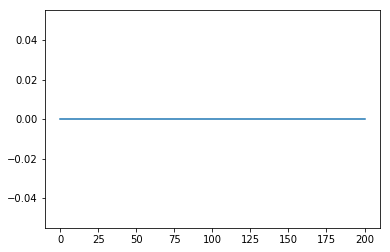

In [18]:
# Control points. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_control_points = trajectory_all_parameters[:, range_control_points]
else:
    trajectory_control_points = trajectory_all_parameters['control_points'][0:number_of_trajectory_points]
    
trajectory_control_points_norm = np.array([np.linalg.norm(elt - initialized_control_points.ravel()) for elt in trajectory_control_points])
plt.plot(x, trajectory_control_points_norm)
plt.show()

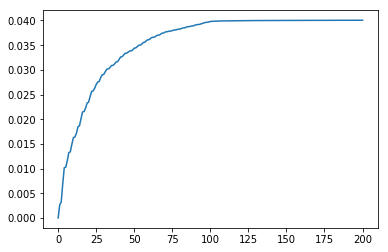

In [19]:
# Momenta. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_momenta = trajectory_all_parameters[:, range_momenta]
else:
    trajectory_momenta = trajectory_all_parameters['momenta'][0:number_of_trajectory_points]

trajectory_momenta_norm = np.array([np.linalg.norm(elt - initialized_momenta.ravel()) for elt in trajectory_momenta])
plt.plot(x, trajectory_momenta_norm)
plt.show()

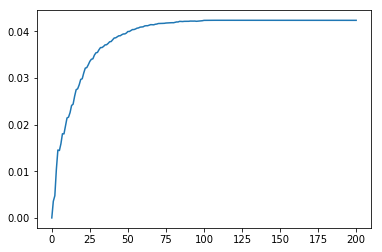

In [20]:
# Control points and momenta: velocity field. 
kernel = kernel_factory.factory('torch', xml_parameters.deformation_kernel_width)

trajectory_velocity_field = []
for (control_points, momenta) in zip(trajectory_control_points, trajectory_momenta): 
    control_points_torch = Variable(torch.from_numpy(control_points.reshape((-1, Settings().dimension))).type(Settings().tensor_scalar_type))
    momenta_torch = Variable(torch.from_numpy(momenta.reshape((-1, Settings().dimension))).type(Settings().tensor_scalar_type))
    velocity_field = kernel.convolve(control_points_torch, control_points_torch, momenta_torch).data.numpy()
    trajectory_velocity_field.append(velocity_field)

trajectory_velocity_field_norm = np.array([np.linalg.norm(elt - trajectory_velocity_field[0]) for elt in trajectory_velocity_field])
plt.plot(x, trajectory_velocity_field_norm)
plt.show()

In [21]:
# Modulation matrix: reconstructed space-shifts.

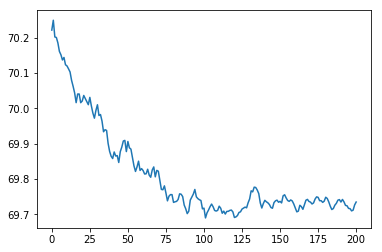

In [22]:
# Reference time. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_reference_time = trajectory_all_parameters[:, range_reference_time]
else:
    trajectory_reference_time = trajectory_all_parameters['reference_time'][0:number_of_trajectory_points]
    
plt.plot(x, trajectory_reference_time)
plt.show()

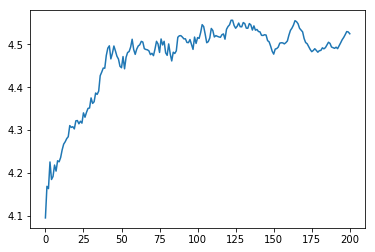

In [23]:
# Time-shift variance. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_time_shift_variance = trajectory_all_parameters[:, range_time_shift_variance]
else:
    trajectory_time_shift_variance = trajectory_all_parameters['time_shift_variance'][0:number_of_trajectory_points]

plt.plot(x, np.sqrt(trajectory_time_shift_variance))
plt.show()

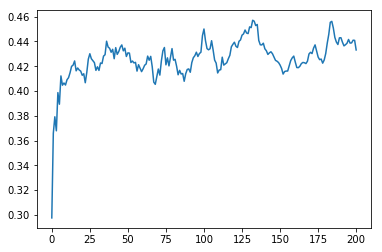

In [24]:
# Log-acceleration variance. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_log_acceleration_variance = trajectory_all_parameters[:, range_log_acceleration_variance]
else:
    trajectory_log_acceleration_variance = trajectory_all_parameters['log_acceleration_variance'][0:number_of_trajectory_points]

plt.plot(x, np.sqrt(trajectory_log_acceleration_variance))
plt.show()

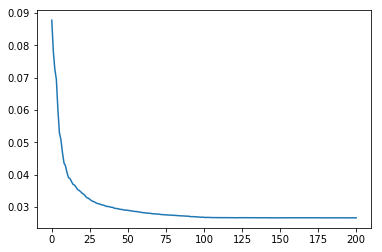

In [25]:
# Noise variance. 
if os.path.isfile(path_to_trajectory_txt):
    trajectory_noise_variance = trajectory_all_parameters[:, range_noise_variance]
else:
    trajectory_noise_variance = trajectory_all_parameters['noise_variance'][0:number_of_trajectory_points]

plt.plot(x, np.sqrt(trajectory_noise_variance))
plt.show()